Model Accuracy: 0.7025641025641025
Timestamp: 1970-01-01T05:47:17 - Actual: Normal, Predicted: Normal
Timestamp: 1969-12-31T09:09:11 - Actual: Suspicious, Predicted: Suspicious
Timestamp: 1970-01-01T05:55:00 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T10:12:54 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T05:00:26 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T07:43:03 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T07:20:31 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T09:35:47 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T10:55:10 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T06:25:13 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T04:35:09 - Actual: Suspicious, Predicted: Suspicious
Timestamp: 1969-12-31T13:46:09 - Actual: Normal, Predicted: Suspicious
Timestamp: 1970-01-01T06:41:36 - Actual: Normal, Predicted: Normal
Timestamp: 1970-01-01T04:30:01 - Actual: Suspicious, Predicted: Suspicious

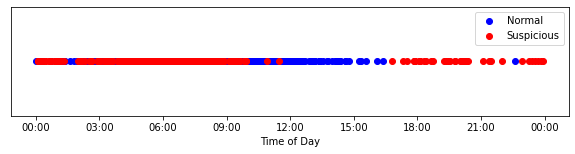

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import re
from datetime import datetime

# Function to extract timestamps from files
def extract_timestamps(file_paths):
    timestamps = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith("Date:"):
                    # Extract the date string from the line
                    date_str = re.search(r"Date:\s+(.*)", line).group(1)
                    # Convert to datetime and then to Unix timestamp
                    date_obj = datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y %z")

                    # remove month and day and year from the date
                    date_obj = date_obj.replace(month=1, day=1, year=1970)

                    timestamps.append(date_obj.timestamp())  # Convert to Unix timestamp
    return timestamps

# Provide your list of file paths
normal_data = ["not-malicious/lasse-xz-commits.txt"]
suspicious_data = ["malicious/jia-libarchive-commits.txt", "malicious/jia-xz-commits.txt", "malicious/right9ctrl-es-commits.txt", "malicious/sawly-ez-commits.txt"]

# Extract timestamps from normal and suspicious data files
normal_timestamps = extract_timestamps(normal_data)
suspicious_timestamps = extract_timestamps(suspicious_data)


zipped_timestamps = list(zip(normal_timestamps, suspicious_timestamps))
normal_timestamps = [x[0] for x in zipped_timestamps]
suspicious_timestamps = [x[1] for x in zipped_timestamps]




# Combine data and labels
timestamps = normal_timestamps + suspicious_timestamps
labels = [0] * len(normal_timestamps) + [1] * len(suspicious_timestamps)  # 0 for normal, 1 for suspicious

# Prepare the data for training
X = np.array(timestamps).reshape(-1, 1)
y = np.array(labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy:", accuracy)

# print some stats to help understand the data
# and some prredictions

# Make predictions for all items in X_test
y_test_predictions = model.predict(X_test)

num_false_positives = 0
num_false_negatives = 0
num_true_positives = 0
num_true_negatives = 0

# Print each timestamp in X_test along with the prediction
for i in range(len(X_test)):
    actual_label = "Suspicious" if y_test[i] == 1 else "Normal"
    predicted_label = "Suspicious" if y_test_predictions[i] == 1 else "Normal"
    timestamp = datetime.fromtimestamp(X_test[i][0]).isoformat()
    print(f"Timestamp: {timestamp} - Actual: {actual_label}, Predicted: {predicted_label}")

    # Count the number of false positives, false negatives, true positives, and true negatives
    if y_test[i] == 0 and y_test_predictions[i] == 0:
        num_true_negatives += 1
    elif y_test[i] == 0 and y_test_predictions[i] == 1:
        num_false_positives += 1
    elif y_test[i] == 1 and y_test_predictions[i] == 0:
        num_false_negatives += 1
    elif y_test[i] == 1 and y_test_predictions[i] == 1:
        num_true_positives += 1


# print a table of the stats
print("\nConfusion Matrix:")
print(f"{'':<20}{'Predicted Normal':<20}{'Predicted Suspicious':<20}")
print(f"{'Actual Normal':<20}{num_true_negatives:<20}{num_false_positives:<20}")
print(f"{'Actual Suspicious':<20}{num_false_negatives:<20}{num_true_positives:<20}")

# true negative rate
print("\nTrue Positive Rate:", num_true_positives / (num_true_positives + num_false_negatives))




import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime

# Convert timestamps to time of day (hour and minute)
normal_times_of_day = [datetime.fromtimestamp(ts).strftime('%H:%M') for ts in normal_timestamps]
suspicious_times_of_day = [datetime.fromtimestamp(ts).strftime('%H:%M') for ts in suspicious_timestamps]

# Convert time strings to a format that matplotlib can understand for plotting
normal_times_numeric = [datetime.strptime(time, '%H:%M') for time in normal_times_of_day]
suspicious_times_numeric = [datetime.strptime(time, '%H:%M') for time in suspicious_times_of_day]

# Create scatter plot
plt.figure(figsize=(10, 2))  # Adjust height for a more line-like look
plt.scatter(normal_times_numeric, [0] * len(normal_times_numeric), color='blue', label='Normal')
plt.scatter(suspicious_times_numeric, [0] * len(suspicious_times_numeric), color='red', label='Suspicious')

# Hide y-axis
plt.gca().get_yaxis().set_visible(False)

# Format x-axis to show time
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Add legend and labels
plt.xlabel("Time of Day")
plt.legend()
plt.show()







In [6]:
MISLABEL_PERCENTAGE = 0.2

import random
import re
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import (pack_padded_sequence, pad_packed_sequence,
                                pad_sequence)
from torch.utils.data import DataLoader, Dataset
from math import floor


# Function to extract sequences of timestamps from files
def extract_sequences(file_paths):
    sequences = []
    for file_path in file_paths:
        timestamps = []
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith("Date:"):
                    # Extract the date string from the line
                    date_str = re.search(r"Date:\s+(.*)", line).group(1)
                    # Convert to datetime and then to Unix timestamp
                    date_obj = datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y %z")

                    # Remove month, day, and year from the date
                    date_obj = date_obj.replace(month=1, day=1, year=1970)

                    timestamps.append(date_obj.timestamp())  # Convert to Unix timestamp
        sequences.append(timestamps)

    return sequences

# Provide your list of file paths
normal_data = [
    "not-malicious/lasse-xz-commits.txt", 
    "not-malicious/eggert-tz-commits.txt", 
    "not-malicious/jdalton-lodash-commits.txt"
]
suspicious_data = [
    "malicious/jia-libarchive-commits.txt",
    "malicious/jia-xz-commits.txt",
    "malicious/right9ctrl-es-commits.txt",
    "malicious/sawly-ez-commits.txt"
]

# Extract sequences from normal and suspicious data files
normal_sequences = extract_sequences(normal_data)
suspicious_sequences = extract_sequences(suspicious_data)

def chop_up_sequences(sequences, max_length):
    chopped_sequences = []
    for seq in sequences:
        num_added = 0
        for i in range(0, len(seq)):
            chopped_sequences.append(seq[i:i+max_length])
            num_added += 1
    return chopped_sequences

normal_sequences = chop_up_sequences(normal_sequences, max_length=10)
suspicious_sequences = chop_up_sequences(suspicious_sequences, max_length=10)

print("Total number of normal sequences:", len(normal_sequences))
print("Total number of suspicious sequences:", len(suspicious_sequences))

smaller_set_size = min(len(normal_sequences), len(suspicious_sequences))
normal_sequences = random.sample(normal_sequences, smaller_set_size)
suspicious_sequences = random.sample(suspicious_sequences, smaller_set_size)

# Combine sequences and labels
sequences = normal_sequences + suspicious_sequences
labels = [0] * len(normal_sequences) + [1] * len(suspicious_sequences)

# Split into training and testing sets
sequences_train, sequences_test, labels_train, labels_test = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

# Mislabel MISLABEL_PERCENTAGE of the training data
mislabel_idx = random.sample(range(len(labels_train)), floor(MISLABEL_PERCENTAGE * len(labels_train)))
for idx in mislabel_idx:
    labels_train[idx] = 1 if labels_train[idx] == 0 else 0


# Define a custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        # Normalize the sequences
        all_timestamps = np.concatenate(sequences)
        mean = all_timestamps.mean()
        std = all_timestamps.std()
        self.sequences = [torch.tensor((np.array(seq) - mean) / std, dtype=torch.float32) for seq in sequences]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function to pad sequences and return lengths
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)

    return sequences_padded, labels, lengths

# Create datasets and loaders
train_dataset = SequenceDataset(sequences_train, labels_train)
test_dataset = SequenceDataset(sequences_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

# Define the RNN model with packed sequences
class RNNClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, lengths):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Pack the sequences
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        # Forward propagate LSTM
        out_packed, _ = self.lstm(x_packed, (h0, c0))
        # Unpack the sequences
        out_unpacked, _ = pad_packed_sequence(out_packed, batch_first=True)
        # Get the outputs from the last valid time step for each sequence
        idx = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, self.hidden_size)
        last_outputs = out_unpacked.gather(1, idx).squeeze(1)
        # Decode the hidden state of the last time step
        out = self.fc(last_outputs)
        out = torch.sigmoid(out)
        return out.squeeze()

print(f"Training on {len(sequences_train)} sequences")


# Initialize the model, criterion, and optimizer
model = RNNClassifier(num_layers=2, hidden_size=16)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    for sequences, labels, lengths in train_loader:
        # Clear gradients
        optimizer.zero_grad()
        # Prepare input
        sequences = sequences.unsqueeze(-1)  # Shape: (batch_size, seq_len, 1)
        # Forward pass
        outputs = model(sequences, lengths)
        outputs = outputs.view(-1)  # Ensure outputs are of shape (batch_size)
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# print number of false positives, false negatives, true positives, and true negatives
num_false_positives = 0
num_false_negatives = 0
num_true_positives = 0
num_true_negatives = 0

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for sequences, labels, lengths in test_loader:
        sequences = sequences.unsqueeze(-1)  # Shape: (batch_size, seq_len, 1)
        outputs = model(sequences, lengths)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of false positives, false negatives, true positives, and true negatives
        fp = ((predicted == 1) & (labels == 0)).sum().item()
        fn = ((predicted == 0) & (labels == 1)).sum().item()
        tp = ((predicted == 1) & (labels == 1)).sum().item()
        tn = ((predicted == 0) & (labels == 0)).sum().item()
        num_false_positives += fp
        num_false_negatives += fn
        num_true_positives += tp
        num_true_negatives += tn

    print(f'Accuracy of the model on the test sequences: {100 * correct / total}%')

# print a table of the stats
print("\nConfusion Matrix:")
print(f"{'':<20}{'Predicted Normal':<20}{'Predicted Suspicious':<20}")
print(f"{'Actual Normal':<20}{num_true_negatives:<20}{num_false_positives:<20}")
print(f"{'Actual Suspicious':<20}{num_false_negatives:<20}{num_true_positives:<20}")

# true positive rate
print("\nTrue Positive Rate:", num_true_positives / (num_true_positives + num_false_negatives))

Total number of normal sequences: 5015
Total number of suspicious sequences: 487
Training on 779 sequences
Epoch [1/4], Loss: 0.2342
Epoch [2/4], Loss: 0.2272
Epoch [3/4], Loss: 0.2245
Epoch [4/4], Loss: 0.2223
Accuracy of the model on the test sequences: 82.05128205128206%

Confusion Matrix:
                    Predicted Normal    Predicted Suspicious
Actual Normal       68                  30                  
Actual Suspicious   5                   92                  

True Positive Rate: 0.9484536082474226
